# 12강 CAM

CAM(Class Activation Map)은 설명 가능한 AI 기술 중 하나다. **이미지 내에서 어느 부분이 모델의 의사결정에 큰 영향을 미쳤는지를 시각화하는 기술이다.**

Reference: "Learning Deep Features for Discriminative Localization" by B. Zhou et al., 2015"

## 12.1 라이브러리 호출 및 구글드라이브 연동

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch

/content/drive/MyDrive/Colab_Notebooks/deeplearningbro/pytorch


## 12.2 데이터 및 모델 생성

In [5]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96x96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

# 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [7]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 12.3 모델 학습

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [9]:
for epoch in range(20):

    running_loss = 0.0
    for data in trainloader:
        
        inputs, labels = data[0].to(device), data[1].to(device)
          
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  

torch.save(model.state_dict(), './models/stl10_resnet18.pth')      

print('Finished Training')

[1] loss: 0.591
[2] loss: 0.110
[3] loss: 0.037
[4] loss: 0.024
[5] loss: 0.098
[6] loss: 0.159
[7] loss: 0.075
[8] loss: 0.056
[9] loss: 0.042
[10] loss: 0.075
[11] loss: 0.059
[12] loss: 0.087
[13] loss: 0.058
[14] loss: 0.056
[15] loss: 0.050
[16] loss: 0.050
[17] loss: 0.077
[18] loss: 0.081
[19] loss: 0.066
[20] loss: 0.047
Finished Training


In [10]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))

Accuracy of the network on the train images: 98 %


## 12.4 모델 구조

CAM의 어느 부분이 정확도를 98%로 했을까?

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`(avgpool): AdaptiveAvgPool2d(output_size=(1, 1))` 바로 직전이 Feature Extraction 부분에 해당되는 부분인데. CAM은 FE의 마지막 FEature map을 기준으로 해서 시각화를 하는 모델
- layer 4의 `(bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))`이 값을 얻고, 각 FE맵에 해당하는 가중치를 fc에서 구하다가 곱함
- Fc의 가중치를 얻어서 FE과의 가중치를 서로 곱함

## 12.5 CAM 모델 구축

In [12]:
# Visualize feature maps
activation = {}
def get_activation(name): # 모델 내에서 filter나 feature map등을 끄집어낼 때 쓰는 함수 / 전체를 한 덩어리(양식)라고 생각
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [13]:
def cam(model, trainset, img_sample, img_size):

    '''
    - img_sample :  이미지 번호로 for문을 돌면서 번호가 하나씩 들어가는 것입니다. 즉, 이미지 한 장 받아서 한 장의  CAM 이미지를 만드는 것입니다.
    - model.layer4[1].bn2.register_forward_hook(get_activation('final')) : 여기서 'final'은 임의로 name을 정하신건가요?
    - data.unsqueeze_(0) 차원을 늘린 이유 
      : CNN 모델에 데이터를 넣으려면 크기가 4차원이 되어야 하는데 한 장을 불러왔기 때문에 3차원 이미지입니다. 
        따라서 unsqueeze를 통해 0번째 크기를 1로 만들어서 크기가 (채널, 너비, 높이)인 이미지를 (1,채널, 너비, 높이) 크기로 변경하는 것입니다. 
        참고로 unsqueeze_는 인플래이스 방식으로 data에 data.unsqueeze를 바로 업데이트 해줍니다 :)
    '''

    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final')) # feature extraction의 마지막 feature map 구하기
        data, label = trainset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]
        output = model(data.to(device))
        _, prediction = torch.max(output, 1)
        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기
        
        for idx in range(act.size(0)): # CAM 연산
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] # 각 라벨에 해당하는 가중치 곱함 :: act -> feature map
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기 
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        # feature map은 일반적으로 original img보다 사이즈가 적어서 크게 해주기 위해 resize
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size)) 
        
    return cam_img, original_img

In [14]:
def plot_cam(model, trainset, img_size, start):
    end = start + 20  # 결괏값 20개
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 5))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()

    for i in range(start, end):
        cam_img, original_img = cam(model, trainset, i, img_size)

        axs[i - start].imshow(original_img, cmap='gray') # 오리지널 이미지에
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.5) # cam이미지를 덮어씌우는 형태
        axs[i - start].axis('off')

    plt.show()
    fig.savefig('cam.png')

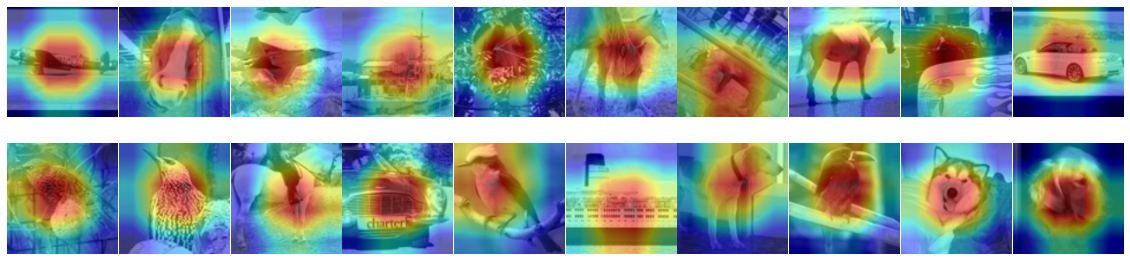

In [15]:
plot_cam(model, trainset, 128, 10)